# RAG for Guest Stories - Hugging Face

In [145]:
import langchain_core as lc
import langchain_openai
import langgraph as lg
import langgraph.prebuilt as lp
from langchain_community.llms import HuggingFaceHub 

In [146]:
import os

os.sys.path.append("./")

# Credentials

In [147]:
import getpass

# TODO: Migrate to utils script
def _get_var(var) -> None:
    if os.getenv(var):
        print("Variable already exists.")
    else:
        os.environ[var] = getpass.getpass(prompt=f"Type the value of {var}: ")

var = "HUGGINGFACEHUB_API_TOKEN"
_get_var(var)
hf_token = os.getenv(var)

Variable already exists.


# Basic Agent

In [148]:
from langgraph.graph import END, START, StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [149]:
# TODO: fix hf token gathering

#load_dotenv(dotenv_path=".venv/")
#hf_token = os.getenv("HUGGINGFACEHUB_API_TOKEN")
#print(hf_token)

In [150]:
# Build AGent State Graph


In [151]:
from typing import TypedDict, Any
from langchain.schema import AIMessage, HumanMessage
from langchain_core import *
from typing import Literal, TypedDict
#from langgraph import Edge

In [152]:
# 0/4 import tools

from tools import search_tool, weather_tool
from rag import RAGTool

In [153]:
from langchain_core.messages import BaseMessage
from typing import List

In [154]:
# 1/4 State

class GalaState(TypedDict):
    messages: List[BaseMessage]
    intermediate_steps: list
    done: bool

In [155]:
# TODO: Migrate _get_var to utils script

import getpass

def _get_var(var) -> None:
    if os.getenv(var):
        print(f"{var} successfully processed")
    else:
        os.environ[var] = getpass.getpass(prompt=f"Type the value of {var}: ")
        
_get_var("OPENAI_API_KEY")

OPENAI_API_KEY successfully processed


In [156]:
from langchain_core.messages import HumanMessage, AIMessage

In [157]:
# 2/4 Nodes
from langchain_core.runnables import Runnable
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

#def llm(state: GalaState,  ai_model: Any) -> None:
#    response = ai_model.invoke(state)  # TODO: Process correctly the state
#    return response 

model = ChatOpenAI(model="gpt-3.5-turbo")
tools = [RAGTool, weather_tool, search_tool]
tools_node = ToolNode(tools)
model_with_tools = model.bind_tools(tools)

# Q: How to get the user query. What if he has another response? They must run a new agent call? does the agent forgets?
def agent(state: GalaState) -> GalaState:   
    textual_description = """
    LLM model. Reasons and observes the GalaState to make a decision or prompt a response.

    Parameters
    ----------
    state : GalaState
        Information about the chat. It has the following keys: graph_state, chat_history, next_node
    
    Returns:
        type: GalaState
    
    Example:
        >>> agent({"messages": "Who is Batman"})
        Batman is a cool superhero
    """
    chat_history = state.get("messages", [])
    
    formatted_messages = [
        {"role": "user" if msg.type == "human" else "assistant", "content": msg.content}
        for msg in chat_history
    ]
    response = model_with_tools.invoke(input=formatted_messages)
    
    result = {
        "messages": state.get("messages", []) + [response]
    }
    
    # Handle tool calls if they exist
    if hasattr(response, "tool_calls") and response.tool_calls:
        # This will trigger the tool execution in LangGraph
        return {"messages": chat_history + [response]}
    
    # For regular responses
    return {
        "messages": chat_history + [response],
        **{k: v for k, v in state.items() if k != "messages"}  # Preserve other state
    }

#agent_model = Runnable(llm)
#agent_node = Runnable(agent_tools)


In [158]:
# 3/4 Edges


# Start -> LLM call
#Edge(START, llm)

# LLM -> Tools | END 
def should_use_tool(state: GalaState) -> Literal["tools", "end"]:  
    """"
    Determine whether to use tools based on the agent's last response
    """
    
    last_message = state.get("messages", [])[-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        next_node = "tools" 
    else: 
        next_node = "end"  
        
    return next_node
    
# Tools -> LLM
#EDGE("tools", "llm")

#EDGE("llm", END)

In [167]:
# 3/4 Build the graph

builder = StateGraph(state_schema=GalaState)

# Add nodes
builder.add_node("agent", agent)
builder.add_node("tools", tools_node)

# Add edges
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    should_use_tool,
    {"tools": "tools", "end": END}
)
builder.add_edge("tools", "agent") # Agent processes tool results
builder.add_edge("agent", END) # Define a direct edge to END after the agent runs (either initially or after tools)

agent_graph = builder.compile()

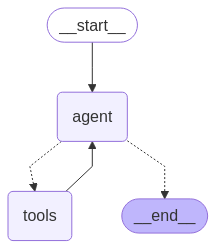

In [168]:
# 4/4 Visualize

from IPython.display import display, Image

display(Image(agent_graph.get_graph().draw_mermaid_png()))

# Testing Phase

In [169]:
prompt_1 = "Hi. Tell me please Who is Ada and Which will be the story to tell about she?"
prompt_2 = "Hi. Tell me please Which was the result of the match Barcelona vs Inter today for the 24/25 Champions League Semifinal"
prompt_3 = "Hi. Tell me please how's the weather today at Barcelona"

In [170]:
response_1 = agent_graph.invoke({"messages": [HumanMessage(content=prompt_1)]})

INFO:tools:WEATHER_API_KEY successfully processed
INFO:tools:WEATHER_API_KEY successfully processed
INFO:tools:WEATHER_API_KEY successfully processed
INFO:tools:WEATHER_API_KEY successfully processed
INFO:tools:WEATHER_API_KEY successfully processed
INFO:tools:WEATHER_API_KEY successfully processed
INFO:tools:WEATHER_API_KEY successfully processed


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:

response_2 = agent_graph.invoke({"messages": [HumanMessage(prompt_2)]})


In [ ]:

response_3 = agent_graph.invoke({"messages": [HumanMessage(prompt_3)]})
